# Neo4j MCP Tools with LangGraph (HTTP Pattern)

This notebook demonstrates using MCP tools with LangGraph via HTTP transport - clean and simple!

In [1]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

## Step 1: Deploy the HTTP-enabled MCP service

The HTTP service has been deployed using:
```bash
./scripts/deploy-mcp-http.sh
```

This runs alongside the original pod (Claude Desktop still works!).

## Step 2: Connect to MCP HTTP Service

Since your code runs on minisforum, you can use NodePort directly (no port-forward needed):

```python
# For code running on minisforum (your case):
client = MultiServerMCPClient({
    "neo4j": {
        "url": "http://localhost:31380/mcp",  # NodePort 31380
        "transport": "streamable_http",
    }
})

# Alternative - For local development from laptop:
# First run: kubectl port-forward -n mcp-services service/mcp-neo4j-cypher-http 8080:8000
# Then use: "url": "http://localhost:8080/mcp"
```

### Official Simplest Pattern

In [1]:


from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from eventtrader import keys  # This enables tracing

# 1. Connect to MCP
client = MultiServerMCPClient({
    "neo4j": {
        "url": "http://localhost:31380/mcp",
        "transport": "streamable_http",
    }
})

# 2. Get tools
tools = await client.get_tools()

# 3. Create agent with tools - THAT'S IT!
agent = create_react_agent("openai:gpt-4", tools)

# 4. Use it
response = await agent.ainvoke({
    "messages": [{"role": "user", "content": "Find and list any one node in my the database?"}]
})

print(response)


{'messages': [HumanMessage(content='Find and list any one node in my the database?', additional_kwargs={}, response_metadata={}, id='9e4e0284-7dfc-43da-b7fa-179157865df8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7ZzJj9sETtgCY8hsApcVQrYD', 'function': {'arguments': '{\n  "query": "MATCH (n) RETURN n LIMIT 1"\n}', 'name': 'read_neo4j_cypher'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 215, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BxOdXWUeyKIVyDMzNUkjvC4PQFlfv', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b1819c01-0739-434b-bce0-34f36373ebe0-0', tool_calls=[{'name': 'read_neo4j_cypher', 'arg

## Step 3: Test MCP Connection

In [3]:
# Quick test - Verify MCP HTTP is working
async def quick_test():
    # Using NodePort 31380 (no port-forward needed on minisforum)
    client = MultiServerMCPClient({
        "neo4j": {
            "url": "http://localhost:31380/mcp",
            "transport": "streamable_http",
        }
    })
    
    # Get tools
    tools = await client.get_tools()
    print(f"✅ Found {len(tools)} MCP tools: {[t.name for t in tools]}")
    
    # Test a query
    read_tool = next(t for t in tools if t.name == "read_neo4j_cypher")
    result = await read_tool.ainvoke({
        "query": "MATCH (c:Company) RETURN c.name LIMIT 3"
    })
    print(f"✅ Query result: {result}")

await quick_test()

✅ Found 3 MCP tools: ['get_neo4j_schema', 'read_neo4j_cypher', 'write_neo4j_cypher']
✅ Query result: [{"c.name": "FMC CORP"}, {"c.name": "SCOTTS MIRACLE-GRO CO"}, {"c.name": "FLOWSERVE CORP"}]


## Step 4: Complete Working Example (Router Pattern)

In [4]:
# Complete working example following router.ipynb pattern
async def create_mcp_graph():
    """Create a LangGraph with MCP tools - clean and simple."""
    
    # 1. Get MCP tools using NodePort (no port-forward needed)
    client = MultiServerMCPClient({
        "neo4j": {
            "url": "http://localhost:31380/mcp",
            "transport": "streamable_http",
        }
    })
    tools = await client.get_tools()
    print(f"✅ Loaded {len(tools)} MCP tools via NodePort 31380")
    
    # 2. Create LLM with tools (requires OpenAI API key)
    # llm = ChatOpenAI(model="gpt-4", temperature=0)
    # llm_with_tools = llm.bind_tools(tools)
    
    # 3. Define the tool-calling node
    def tool_calling_llm(state: MessagesState):
        """Node that calls the LLM with tools."""
        # return {"messages": [llm_with_tools.invoke(state["messages"])]}
        # For testing without OpenAI, just echo the message
        return {"messages": state["messages"]}
    
    # 4. Build the graph
    builder = StateGraph(MessagesState)
    
    # Add nodes
    builder.add_node("tool_calling_llm", tool_calling_llm)
    builder.add_node("tools", ToolNode(tools))  # MCP tools work like any tools!
    
    # Add edges (following router.ipynb pattern)
    builder.add_edge(START, "tool_calling_llm")
    builder.add_conditional_edges(
        "tool_calling_llm",
        lambda x: END,  # For testing, always end (normally use tools_condition)
    )
    builder.add_edge("tools", "tool_calling_llm")
    
    # 5. Compile the graph
    graph = builder.compile()
    
    return graph, tools

# Create the graph
graph, tools = await create_mcp_graph()
print(f"✅ Graph created with {len(tools)} tools available")

✅ Loaded 3 MCP tools via NodePort 31380
✅ Graph created with 3 tools available


In [5]:
# Direct tool testing (works without OpenAI API key)
async def test_mcp_tools_directly():
    """Test MCP tools directly without LLM."""
    
    # Create MCP client and get tools
    client = MultiServerMCPClient({
        "neo4j": {
            "url": "http://localhost:31380/mcp",  # Using NodePort
            "transport": "streamable_http",
        }
    })
    
    # Get tools
    tools = await client.get_tools()
    print(f"✅ Connected to Neo4j MCP! Found {len(tools)} tools:")
    for tool in tools:
        print(f"  - {tool.name}: {tool.description}")
    
    # Test 1: Get database schema
    print("\n📊 Test 1: Getting database schema...")
    schema_tool = next(t for t in tools if t.name == "get_neo4j_schema")
    schema_result = await schema_tool.ainvoke({})
    print(f"Schema result type: {type(schema_result)}")
    print(f"Schema result (truncated): {str(schema_result)[:200]}...")
    
    # Test 2: Query for node labels
    print("\n📊 Test 2: Querying node labels...")
    read_tool = next(t for t in tools if t.name == "read_neo4j_cypher")
    labels_result = await read_tool.ainvoke({
        "query": "CALL db.labels() YIELD label RETURN label ORDER BY label LIMIT 10"
    })
    print(f"Labels result type: {type(labels_result)}")
    print(f"First 10 labels: {labels_result}")
    
    # Test 3: Count nodes by type
    print("\n📊 Test 3: Count nodes by type...")
    count_result = await read_tool.ainvoke({
        "query": "MATCH (n) RETURN labels(n)[0] as type, count(n) as count ORDER BY count DESC LIMIT 3"
    })
    print(f"Top 3 node types: {count_result}")
    
    return tools

# Run it
tools = await test_mcp_tools_directly()

✅ Connected to Neo4j MCP! Found 3 tools:
  - get_neo4j_schema: List all node, their attributes and their relationships to other nodes in the neo4j database.
        If this fails with a message that includes "Neo.ClientError.Procedure.ProcedureNotFound"
        suggest that the user install and enable the APOC plugin.
        
  - read_neo4j_cypher: Execute a read Cypher query on the neo4j database.
  - write_neo4j_cypher: Execute a write Cypher query on the neo4j database.

📊 Test 1: Getting database schema...
Schema result type: <class 'str'>
Schema result (truncated): [{"label": "MarketIndex", "attributes": {"id": "STRING unique indexed", "ticker": "STRING", "etf": "STRING", "name": "STRING"}, "relationships": {}}, {"label": "Sector", "attributes": {"id": "STRING u...

📊 Test 2: Querying node labels...
Labels result type: <class 'str'>
First 10 labels: [{"label": "Abstract"}, {"label": "AdminReport"}, {"label": "AdminSection"}, {"label": "Company"}, {"label": "Concept"}, {"label": "

In [6]:
# Real LangGraph Agent with MCP Tools (Requires OpenAI API Key)
import os

# Set your API key
# os.environ["OPENAI_API_KEY"] = "sk-your-key-here"

async def run_neo4j_explorer():
    """Real example following langchain-academy router pattern."""
    
    # 1. Get MCP tools
    client = MultiServerMCPClient({
        "neo4j": {
            "url": "http://localhost:31380/mcp",  # Using NodePort
            "transport": "streamable_http",
        }
    })
    tools = await client.get_tools()
    
    # 2. Create LLM with tools
    llm = ChatOpenAI(model="gpt-4", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    
    # 3. Define the agent node (router.ipynb pattern)
    def agent(state: MessagesState):
        """Agent node that decides whether to use tools."""
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
    # 4. Build the graph
    builder = StateGraph(MessagesState)
    
    # Add nodes
    builder.add_node("agent", agent)
    builder.add_node("tools", ToolNode(tools))
    
    # Add edges (router pattern)
    builder.add_edge(START, "agent")
    builder.add_conditional_edges(
        "agent",
        tools_condition,
        # If tools_condition returns "tools", go to tools node
        # If it returns "__end__", go to END
    )
    builder.add_edge("tools", "agent")
    
    # 5. Compile
    graph = builder.compile()
    
    # 6. Run queries
    queries = [
        "What types of nodes exist in the database? List the first 10.",
        "How many Report nodes are there in the database?",
        "Show me 3 companies (Company nodes) with their names.",
    ]
    
    for query in queries:
        print(f"\n🔍 Query: {query}")
        result = await graph.ainvoke({
            "messages": [HumanMessage(content=query)]
        })
        print(f"💬 Response: {result['messages'][-1].content}")

# Uncomment and run after setting OPENAI_API_KEY:
await run_neo4j_explorer()


🔍 Query: What types of nodes exist in the database? List the first 10.
💬 Response: Here are the first 10 types of nodes that exist in the database:

1. **MarketIndex**: Attributes include id, ticker, etf, name.
2. **Sector**: Attributes include id, etf, name. It has a relationship "BELONGS_TO" with MarketIndex.
3. **Industry**: Attributes include id, sector_id, etf, name. It has a relationship "BELONGS_TO" with Sector.
4. **Company**: Attributes include sector, shares_out, displayLabel, symbol, industry_normalized, sector_etf, industry_etf, id, cik, fiscal_year_end_month, ticker, mkt_cap, name, industry, exchange, employees, fiscal_year_end_day. It has relationships "HAS_TRANSCRIPT" with Transcript, "DECLARED_SPLIT" with Split, "DECLARED_DIVIDEND" with Dividend, "RELATED_TO" with Company, "BELONGS_TO" with Industry.
5. **Concept**: Attributes include id, balance, type_local, category, qname, label, period_type, u_id, concept_type, namespace.
6. **Abstract**: Attributes include id, bal

In [7]:
# Simplest One-Node Agent (as originally requested)
async def create_simplest_agent():
    """Simplest LangGraph agent with one node and MCP tools."""
    
    # Get MCP tools
    client = MultiServerMCPClient({
        "neo4j": {
            "url": "http://localhost:31380/mcp",  # Using NodePort
            "transport": "streamable_http",
        }
    })
    tools = await client.get_tools()
    
    # Create graph with single node
    builder = StateGraph(MessagesState)
    
    # Single node that explores the database
    async def explore_db(state: MessagesState):
        """Single node that can query Neo4j."""
        # Direct tool usage example
        read_tool = next(t for t in tools if t.name == "read_neo4j_cypher")
        
        # Get the user's query
        user_query = state["messages"][-1].content
        
        # Execute Cypher based on the prompt
        if "labels" in user_query.lower():
            result = await read_tool.ainvoke({
                "query": "CALL db.labels() YIELD label RETURN label LIMIT 10"
            })
        elif "count" in user_query.lower():
            result = await read_tool.ainvoke({
                "query": "MATCH (n) RETURN labels(n)[0] as type, count(n) as count ORDER BY count DESC LIMIT 5"
            })
        else:
            result = await read_tool.ainvoke({
                "query": "MATCH (n) RETURN n LIMIT 1"
            })
        
        return {"messages": [AIMessage(content=f"Query result: {result}")]}
    
    # Build graph
    builder.add_node("explore", explore_db)
    builder.add_edge(START, "explore")
    builder.add_edge("explore", END)
    
    return builder.compile()

# Usage:
graph = await create_simplest_agent()
result = await graph.ainvoke({"messages": [HumanMessage(content="Show me the labels")]})

In [8]:
result

{'messages': [HumanMessage(content='Show me the labels', additional_kwargs={}, response_metadata={}, id='c62a6f8d-80bc-4f90-b546-e94d85a6cd46'),
  AIMessage(content='Query result: [{"label": "MarketIndex"}, {"label": "Sector"}, {"label": "Industry"}, {"label": "Company"}, {"label": "Concept"}, {"label": "Abstract"}, {"label": "Fact"}, {"label": "Period"}, {"label": "Unit"}, {"label": "Context"}]', additional_kwargs={}, response_metadata={}, id='b2fb578b-b927-4aaf-89b1-475d5358b289')]}

### View Graph

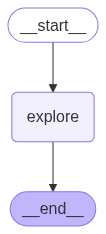

In [ ]:


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Verify Both Setups Are Working

In [10]:
# Verify both setups are working
import subprocess

print("🔍 Checking MCP services:")
result = subprocess.run(["kubectl", "get", "pods", "-n", "mcp-services"], 
                       capture_output=True, text=True)
print(result.stdout)

print("\n✅ mcp-neo4j-cypher: Original pod for Claude Desktop")
print("✅ mcp-neo4j-cypher-http: HTTP pod for LangGraph tools")

🔍 Checking MCP services:
NAME                                    READY   STATUS    RESTARTS   AGE
mcp-neo4j-cypher-5995cf66b7-br6ww       1/1     Running   0          17h
mcp-neo4j-cypher-http-9c56ff686-874p6   1/1     Running   0          15h
mcp-neo4j-memory-64779bf6bb-64ksp       1/1     Running   0          17h


✅ mcp-neo4j-cypher: Original pod for Claude Desktop
✅ mcp-neo4j-cypher-http: HTTP pod for LangGraph tools


## That's It! 🎉

Your MCP tools now work exactly like any other LangChain tool:
- ✅ Simple `MultiServerMCPClient` connection via HTTP
- ✅ Tools work in `create_react_agent`
- ✅ Tools work in custom LangGraph workflows
- ✅ Claude Desktop continues to work (uses the original pod)

No complicated session management, no kubectl exec, just clean HTTP-based tools!